##### Author: Chibueze Ukachi
##### This notebook uses the Q-learning reinforment learning algorithm to calculate the shortest path 

######  Source: http://amunategui.github.io/reinforcement-learning/ . Amunategui's code if for an unweighted graph. 

Modifications were made to make it suitable for a bi-driectional weighted graph:
- Different Reward Matrix
- Different Q-Matrix Initialisation
- Different Update function 
- Different Normaliser

In [1]:
#import relevant libraries
import numpy as np
import pylab as plt
from scipy.sparse import coo_matrix
import pandas as pd
import time

from numpy.random import randint

#### Load NSF Network Topology 

In [2]:
#https://www.researchgate.net/figure/Network-topology-of-NSF-network-consisting-of-14-nodes-and-21-bidirectional-fib
#er-links_fig3_228892289
#the csv was manually created from the graph in the link above
points_list = pd.read_csv("Data/nsf_topology.csv",index_col=0)

points_list.shape

(21, 3)

In [3]:
points_list

,connected,original,weights
0,1,2,1100
1,1,3,1600
2,1,8,2800
3,2,3,600
4,2,4,1000
5,3,6,2000
6,4,5,600
7,4,11,2400
8,5,6,1100
9,5,7,800


#### Initialisation parameters for the network topology

In [4]:
num_nodes = len(np.unique(np.concatenate((points_list["original"].values,points_list["connected"].values))))
start_node = 2
end_node = 9
goal = end_node
num_nodes

14

#### The reward matrix (R_fin) is the adjacency matrix which denotes the possible connections in the graph. 

In [5]:
points_list["connected"] =points_list["connected"].values -1
points_list["original"] =  points_list["original"].values-1

R_fin = -1* coo_matrix((points_list["weights"].values,(points_list["connected"].values,points_list["original"].values)),(num_nodes,num_nodes)).toarray()
#add to transpose so that we make the mappings bi-directional
R_fin += R_fin.T
R_fin

array([[    0, -1100, -1600,     0,     0,     0,     0, -2800,     0,
            0,     0,     0,     0,     0],
       [-1100,     0,  -600, -1000,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [-1600,  -600,     0,     0,     0, -2000,     0,     0,     0,
            0,     0,     0,     0,     0],
       [    0, -1000,     0,     0,  -600,     0,     0,     0,     0,
            0, -2400,     0,     0,     0],
       [    0,     0,     0,  -600,     0, -1100,  -800,     0,     0,
            0,     0,     0,     0,     0],
       [    0,     0, -2000,     0, -1100,     0,     0,     0,     0,
        -1200,     0,     0, -2000,     0],
       [    0,     0,     0,     0,  -800,     0,     0,  -700,     0,
            0,     0,     0,     0,     0],
       [-2800,     0,     0,     0,     0,     0,  -700,     0,  -700,
            0,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,  -700,     0,
         

#### Rather than intialise the Q-matrix memory to zero, the locations of the routers in the NSF topology was given

In [6]:
Q_fin = np.copy(R_fin)
Q_fin[Q_fin<0] = 10*np.max(abs(R_fin))
Q_fin = np.matrix(Q_fin).astype(float)
Q_fin

matrix([[     0.,  28000.,  28000.,      0.,      0.,      0.,      0.,
          28000.,      0.,      0.,      0.,      0.,      0.,      0.],
        [ 28000.,      0.,  28000.,  28000.,      0.,      0.,      0.,
              0.,      0.,      0.,      0.,      0.,      0.,      0.],
        [ 28000.,  28000.,      0.,      0.,      0.,  28000.,      0.,
              0.,      0.,      0.,      0.,      0.,      0.,      0.],
        [     0.,  28000.,      0.,      0.,  28000.,      0.,      0.,
              0.,      0.,      0.,  28000.,      0.,      0.,      0.],
        [     0.,      0.,      0.,  28000.,      0.,  28000.,  28000.,
              0.,      0.,      0.,      0.,      0.,      0.,      0.],
        [     0.,      0.,  28000.,      0.,  28000.,      0.,      0.,
              0.,      0.,  28000.,      0.,      0.,  28000.,      0.],
        [     0.,      0.,      0.,      0.,  28000.,      0.,      0.,
          28000.,      0.,      0.,      0.,      0.,     

#### Initialisation parameters for the network topology

In [7]:
alpha = 0.7 # learning rate
epsilon = 0.1 #exploitation vs exploration
gamma = 0.9
n_episodes = 100

In [8]:
def normaliser(my_Q):
    num = my_Q - np.min(my_Q)
    den = np.max(my_Q)- np.min(my_Q)
    return num/den

#### Tabular Q-learning update equation

$$ Q(S_{t},A_{t}) = Q(S_{t},A_{t}) + \alpha[R_{t+1} + \gamma max Q(S_{t+1},A_{t+1}) - Q(S_{t},A_{t})]   $$

In [9]:
def update_Q_c(my_R,my_Q,current_state, next_state, alpha,gamma):
    """
    This is simply a programmatic representation of the Q-learning formula shown above.
    In addition to a scoring metric to check for convergence
    """
    
    curr_r = my_R[current_state,next_state]
    curr_q = my_Q[current_state,next_state] 
    #for any valid moves in the next state, so where it is greater than 0, we choose the maximum
    #np.where returns array of index of the valid moves
    max_q = np.max(my_Q[next_state,np.where(my_Q[next_state,:]>0)[1]])
    my_Q[current_state,next_state] +=  alpha * (curr_r + (gamma*max_q) - curr_q)     
    #normalised score is an arbritrary metric to check for convergence
    score = normaliser(my_Q)
    return my_Q,score

##### Training the network based on Q-learning algorithm

In [10]:
%%time
scores = []

#play the game for 100 episodes
for e in range(n_episodes):
    current_state = start_node
    goal = False
    local_score = []
    #each game ends once it reaches the destination
    while not goal:
        #index of valid moves which composes of the next state
        valid_moves = np.where(Q_fin[current_state,:] > 0)[1]

        #if there's only one valid option, go there
        if len(valid_moves) <= 1:
            next_state = valid_moves[0]
        else:
            #since multiple options exist, we choose the one with the maximum future reward
            max_val_c = np.max(Q_fin[current_state,valid_moves])
            best_actions_list = np.where(Q_fin[current_state,:]== max_val_c)[1]
            best_action = np.random.choice(best_actions_list)
            if np.random.random() < epsilon:
                #choice that may not be maximum so we can discover new efficient routes 
                valid_moves = valid_moves[np.where(valid_moves != best_action)[0]]       
                next_state = np.random.choice(valid_moves)               
            else:
                #choice with max reward
                next_state = best_action

        mine_Q,score = update_Q_c(R_fin,Q_fin,current_state, next_state, alpha,gamma)
        local_score.append(score)

        if next_state == end_node:
            goal = True
        current_state = next_state
    
    scores.append(np.average(np.array(local_score)))

CPU times: user 48 ms, sys: 0 ns, total: 48 ms
Wall time: 52.4 ms


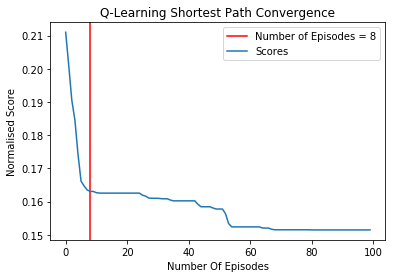

In [22]:

fig, ax = plt.subplots()
plt.axvline(x=8,color='red',label= 'Number of Episodes = 8')
plt.plot(scores,label='Scores')
plt.legend()
plt.xlabel('Number Of Episodes')
plt.ylabel('Normalised Score')
plt.title('Q-Learning Shortest Path Convergence')
plt.show()

In [12]:
fig.savefig('Data/QLearningConvergence.png')

##### Testing the network using only information from the Q-matrix 

In [13]:
%%time

current_state = start_node
node_list = [current_state]
while current_state != end_node:
    #index of valid moves which composes of the next state
    my_moves = np.where(Q_fin[current_state,:] > 0)[1]
    max_value = np.max(Q_fin[current_state,my_moves])

    next_node = np.where(Q_fin[current_state,:]== max_value)[1]
    print("the potential next node is:", next_node)
    if len(next_node)>1: 
        next_node = next_node[i]

    print("I chose:", next_node)

    node_list.append(int(next_node))
    #print(next_node)
    current_state = next_node


print("Shortest path:", node_list)


the potential next node is: [5]
I chose: [5]
the potential next node is: [9]
I chose: [9]
Shortest path: [2, 5, 9]
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 4.93 ms


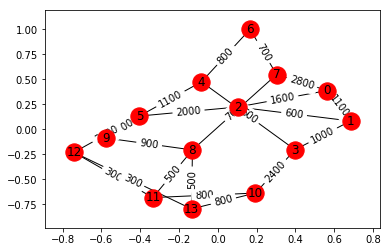

In [14]:
import networkx as nx
fig = plt.figure()
G=nx.Graph()
nx_points_lists = list(zip(points_list["original"].values,points_list["connected"].values,points_list["weights"].values))
G.add_weighted_edges_from(nx_points_lists)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos)
nx.draw_networkx_edges(G,pos)
nx.draw_networkx_labels(G,pos)

labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

plt.show()

In [15]:
%%time
fig.savefig('Data/NSFTopologyNetworkX.png')
#uses dijkstra shortest path algorithm
nx.dijkstra_path(G,start_node,end_node)

CPU times: user 96 ms, sys: 0 ns, total: 96 ms
Wall time: 95.5 ms
